In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import Packages.ClusteringHelper as ch
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

In [3]:
def ricalcola_lista(lista):
    newlist = []
    for i in reversed(range(1, len(lista))):
        newlist = [lista[i] - lista[i-1]] + newlist
    newlist = [lista[0]] + newlist
    return newlist
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    import re
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
def get_scores(path):
    from os import listdir
    from os.path import isfile, join
    import re
    mypath = path
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f != "settings.txt"]
    onlyfiles.sort(key=natural_keys)
    bcubeds = []
    ceafms = []
    for f in onlyfiles:
        with open(join(mypath , f),
                  encoding='utf-8') as t:
            text = t.read()
            match = re.search('bcubed_f1: (\d+.\d+)', text)
            if match:
                bcubeds.append(float(match.group(1)))
            match = re.search('CEAFm: (\d+.\d+)', text)
            if match:
                ceafms.append(float(match.group(1)))
    return bcubeds, ceafms

In [4]:
text, data = ch.read_aida_yago_conll(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\AIDA-YAGO2-dataset.tsv")
save = False
if save:
    text_file = open('text.txt', 'w')
    text_file.write(text)
    text_file.close()
data

,documents,tokens,indexes,word_indexes,mentions,entities,wikidatas,numeric_codes,alpha_codes
0,0,EU,"(0, 2)",0,,,,,
1,0,rejects,"(3, 10)",1,,,,,
2,0,German,"(11, 17)",2,German,Germany,http://en.wikipedia.org/wiki/Germany,11867,/m/0345h
3,0,call,"(18, 22)",3,,,,,
4,0,to,"(23, 25)",4,,,,,
...,...,...,...,...,...,...,...,...,...
285584,1392,younger,"(1342, 1349)",265,,,,,
285585,1392,brother,"(1350, 1357)",266,,,,,
285586,1392,",","(1358, 1359)",267,,,,,
285587,1392,Bobby,"(1360, 1365)",268,Bobby,Bobby_Charlton,http://en.wikipedia.org/wiki/Bobby_Charlton,4224,/m/01c8x


In [5]:
ents_data = data[data['entities'] != ''].copy()

In [6]:
from pathlib import Path

path_train = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_train_encodings.jsonl")
path_testa = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_testa_encodings.jsonl")
path_testb = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_testb_encodings.jsonl")
raw_encodings_train = open(path_train, 'r').read()
raw_encodings_testa = open(path_testa, 'r').read()
raw_encodings_testb = open(path_testb, 'r').read()

In [7]:
import json

jsonl_parsed_train = [json.loads(x) for x in raw_encodings_train.splitlines()]
jsonl_parsed_testa = [json.loads(x) for x in raw_encodings_testa.splitlines()]
jsonl_parsed_testb = [json.loads(x) for x in raw_encodings_testb.splitlines()]
jsonl_parsed = jsonl_parsed_train + jsonl_parsed_testa + jsonl_parsed_testb
encodings = [x['encoding'] for x in jsonl_parsed]

In [8]:
entities = list(ents_data.entities)

In [9]:
ents_dict = {ent:[] for ent in entities}
for i, ent in enumerate(entities):
    ents_dict[ent].append(encodings[i])

In [10]:
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
max_distances = []
for x in tqdm(ents_dict.values()):
    if len(x) > 1:
        max_distances.append(np.max(cdist(x,x, metric='cosine')))

  0%|          | 0/5598 [00:00<?, ?it/s]

In [11]:
# distanza media massima nei cluster
max_distance_mean=np.mean(max_distances)
max_distance_mean

0.03678974213038678

In [12]:
# distanza mediana massima nei cluster
max_distance_median=np.median(max_distances)
max_distance_median

0.029085082846423638

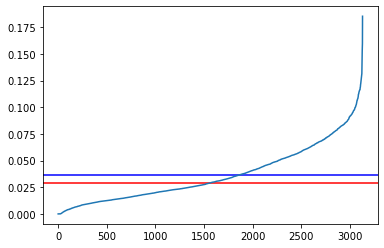

In [13]:
# distribuzione delle distanze massime nei cluster
max_distances.sort()
plt.axhline(y=max_distance_median, color='r', linestyle='-')
plt.axhline(y=max_distance_mean, color='b', linestyle='-')
plt.plot(max_distances)

In [14]:
# varianza dei cluster
var_distances = []
for x in tqdm(ents_dict.values()):
    if len(x) > 1:
        matrix = cdist(x,x, metric='cosine')
        matrix = matrix[~np.eye(matrix.shape[0],dtype=bool)].reshape(matrix.shape[0],-1)

        var_distances.append(np.var(matrix))

  0%|          | 0/5598 [00:00<?, ?it/s]

In [15]:
# media della varianza
np.mean(sorted(var_distances))

0.000135063425200384

In [16]:
# varianza massima
np.max(sorted(var_distances))

0.00261428652061785

In [17]:
#distrubuzione lunghezza cluster
from collections import Counter
from matplotlib.pyplot import figure
lists = sorted(dict(Counter([len(x) for x in ents_dict.values()])).items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
x = [str(el) for el in x]
figure(figsize=(25,5), dpi=1200)
plt.xlabel("Lunghezza del cluster")
plt.ylabel("# elementi")
plt.bar(x, y)
# plt.savefig('./prova2.png')

<BarContainer object of 100 artists>

In [18]:
x = [int(el) for el in x]
np.max(x)

636

In [19]:
# media lunghezza cluster > di 2 elementi
np.mean([len(x) for x in ents_dict.values()])

4.969096105752055

In [20]:
# mediana lunghezza cluster > di 2 elementi
np.median([len(x) for x in ents_dict.values()])

2.0

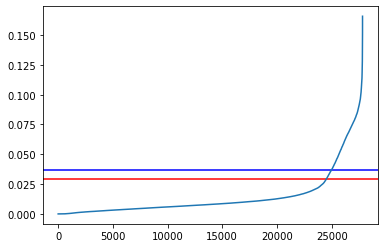

In [21]:
# algoritmo knn con numero di vicini il la lunghezza media di un cluster

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine')
neighbors_fit = neighbors.fit(encodings)
distances, indices = neighbors_fit.kneighbors(encodings)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=max_distance_median, color='r', linestyle='-')
plt.axhline(y=max_distance_mean, color='b', linestyle='-')
plt.plot(distances)

## Tempo di calcolo

In [36]:
step1 = [0, 0.02955555892549455, 0.0425775540061295, 0.05702535901218653, 0.09283031499944627, 0.11677382909692824, 0.1562283649109304, 0.21545089595019817, 0.26278946199454367, 0.3370430839713663, 0.39036286412738264, 0.4479955439455807, 0.5115605830214918, 0.5771538941189647, 0.669986556051299, 0.8026213140692562, 0.9271310430485755, 1.0491257670801133, 1.1734681699890643, 1.318018710007891, 1.4901399319060147, 1.6602164499927312, 1.954965609125793, 2.18233858095482, 2.4574452959932387, 2.7590485110413283, 3.046277812914923, 3.341986854095012, 3.6653793619479984, 3.9865420109126717, 4.465591428102925, 4.881536175031215, 5.370324002113193, 5.901123957941309, 6.43827551510185, 6.985885749105364, 7.553357878932729, 8.137247371021658, 8.8082493590191, 9.448637953028083, 10.23713086405769, 10.953310162993148, 12.336335439933464, 13.074015592923388, 13.818161027040333, 14.648034462938085, 15.492772795027122, 16.368819708935916, 17.280611627968028, 18.22263564891182, 19.210936305113137, 20.180379833094776, 21.21430130698718, 22.221991938073188, 23.271024614106864, 24.317074700957164, 25.405449121957645, 26.602816886035725, 27.768238900927827, 28.98354073893279, 30.222984397085384, 31.858988292049617, 33.50653211795725, 35.784255458042026, 37.45752614992671, 39.14564266591333, 40.821879155002534, 42.50522522605024, 44.237273626960814, 45.98506927699782, 47.80475583509542, 49.68577154702507, 51.549097585026175, 53.57553074811585, 55.71152453799732, 57.82926588994451, 59.953730864916, 62.093543033115566, 64.24334266595542, 67.02396263508126, 69.23624957492575, 71.53928311611526, 73.79921114095487, 76.17545000603423, 78.65994509891607, 81.15404714806937, 83.61104730609804, 86.16717507503927, 88.7388837870676, 91.32757637393661, 93.99814181798138, 96.76500951894559, 100.22684154310264, 103.02821558504365, 105.8490560920909, 108.71856668405235, 111.66951590194367, 114.59353123302571, 117.58210675697774, 120.57839153404348, 123.58000471396372, 126.5743047639262, 130.25578332995065, 133.36260374309495, 136.46677682199515, 139.60499591310509, 142.7328692690935, 145.8646828290075, 149.03843288309872, 152.2963138190098, 155.58756287000142, 158.8761573159136, 162.19892820110545, 166.1166523809079, 169.5478773699142, 172.96865820907988, 176.5913028079085, 180.20174970803782, 183.99054158409126, 188.72700532712042, 193.04598245793022, 197.82988824206404, 202.57319665607065, 207.8358461530879, 212.56481185602024, 217.30248167808168, 222.0753925659228, 226.9459070749581, 231.7613333610352, 236.65684680989943, 241.60908670490608, 247.12016931991093, 252.1869340299163, 257.3092358401045, 262.47248423611745, 268.8565583820455, 274.8799462879542, 280.9101939050015, 286.90260474709794, 293.60671351104975, 299.8004654510878, 306.0203975229524, 312.28938811202534, 318.5973155531101, 324.9123031490017, 331.34354010690004, 338.36256684106775, 344.94108349992894, 351.43263547401875, 357.93218183494173, 364.4626485989429, 371.1002809519414, 377.67890515201725, 384.59670879505575, 391.0937422369607, 397.7010500910692, 404.5230857171118, 411.41118337609805, 418.3881436800584, 425.33393998094834, 432.94032476097345, 440.0521072500851, 447.2465309910476, 454.4845736271236, 461.8590515879914, 469.1993016989436, 476.5497866871301, 484.4665261639748, 492.0954501989763, 499.7572210840881, 507.4976972430013, 515.274778715102, 523.3103197060991, 531.401355664013, 540.0921707861125, 548.246349574998, 556.370525093982, 564.2587950429879, 572.2948891681153, 580.4078219309449, 589.1221066040453, 597.4006629020441, 605.680691706948, 613.9780252159107, 622.371223842958, 630.8433324869256, 639.8864685329609, 648.4211261949968, 656.9907616819255, 665.5462803640403, 674.1472133190837, 682.8041707600933, 692.1211868359242, 700.9512317939661, 709.7838527581189, 718.6661317311227, 727.5029098880477, 736.3115817019716, 745.7519746390171, 754.6809702159371, 763.6661815859843, 772.8365092340391, 781.9642679970711, 791.0931461199652, 800.9667081260122, 810.3017791060265, 819.7258820589632, 829.1860131989233, 838.5620191809721, 848.1461422890425, 858.5846154349856, 868.6002079879399, 878.608957874123, 888.6344410551246, 898.6481008490082, 909.2038038759492, 919.2691360649187, 929.455729882, 939.5111730969511, 949.5529070040211, 959.8558944261167, 970.7661312939599, 981.1492140491027, 991.450535930926, 1002.075836643111, 1013.3917534560896, 1024.6906872170512, 1036.068442153046, 1046.8992762200069, 1057.8740240819752, 1069.0008638459258, 1080.1394094820134, 1091.8938322199974, 1103.2159716989845, 1114.6178785189986, 1126.4188749659806, 1138.2173923030496, 1150.458462035982, 1162.362034807913, 1174.121172837913, 1185.873020295985, 1197.829322729027, 1210.60771324113, 1222.8334738169797, 1235.260133913951, 1247.4798816859256, 1259.8988183909096, 1272.9052593000233, 1285.2982851041015, 1297.8490823910106, 1310.3024881330784, 1322.8553834119812, 1335.9970528590493, 1348.6479884269647, 1361.509253950091, 1374.3907915260643, 1387.1622073089238, 1400.5450602020137, 1413.433467749972, 1426.331567303976, 1439.3055234260391, 1452.3502506790683, 1466.095574151026, 1479.2384197011124, 1492.4114756591152, 1505.8945296630263, 1519.105281800963, 1532.9599860010203, 1546.4154627590906, 1559.6194025359582, 1573.1171000730246, 1586.578817215981, 1600.713527475018, 1614.3821767610498, 1628.0791152119637, 1641.7722961821128, 1655.558928461047, 1670.0379784989636, 1684.0486260671169, 1698.1053368879948, 1712.2219934309833, 1726.9371294430457, 1741.1869306489825, 1755.8715902450494, 1770.4751794040203, 1785.208939397009, 1800.6644924809225, 1815.4781361049972, 1830.2830909739714, 1845.0494144959375, 1860.0341019011103, 1875.8185829219874, 1891.2687317070086, 1906.6569139161147, 1922.094469984062, 1938.1073906130623, 1953.6489576909225, 1969.4193718519527, 1985.074914912926, 2000.720890382072, 2017.0912096109241, 2033.0284789360594, 2048.6330382961314, 2064.288471024018, 2080.5989101140294, 2096.376305124024, 2111.9703636220656, 2127.6925409990363, 2143.4482404820155, 2160.571582468925, 2177.3420033410657, 2193.4593109190464, 2210.2260527769104, 2228.268085218966, 2244.859543238068, 2261.432196123991, 2278.0337338829413, 2295.303897954058, 2312.1068618961144, 2331.621135995025, 2350.703676643083, 2369.831752456026, 2388.4279953120276, 2406.8165204939432, 2425.30479837209, 2443.9865131319966, 2463.2607517880388, 2482.3096682659816, 2501.5940995831043, 2521.074265662115, 2541.050366640091, 2560.4012375709135, 2580.155412985012, 2599.980622023111, 2620.372282555094, 2640.12944592, 2660.01030021091, 2680.262510240078, 2700.8334643191192, 2720.797373021953, 2740.7205227951054, 2760.7878419901244, 2781.4653906230815, 2801.804772048956, 2822.350517750019, 2842.7155121481046, 2863.738505853107, 2884.1603186130524, 2904.721462877933, 2926.9771194709465, 2947.5190858810674, 2970.1084104939364, 2992.0150987680536, 3014.197907865979, 3035.880977798952, 3057.422603195999, 3079.232196022058, 3101.6054200280923, 3123.727752842009, 3145.439775957959, 3167.2684549300466, 3189.907224403927, 3211.9312354139984, 3234.0259480879176, 3256.548944659997, 3278.577220503008, 3300.471846695058, 3322.361916716909, 3345.3423281100113, 3367.6522615009453, 3389.8894173689187, 3411.9469224540517, 3434.970895326929, 3457.5255622661207, 3481.2574748259503, 3505.5833723170217, 3528.9416399761103, 3552.2919711549766, 3575.5967637060676, 3599.2246133629233, 3622.6230488829315, 3646.9433025680482, 3670.697372677969, 3694.2855734110344, 3717.7324194659013, 3741.318480616901, 3765.345808007056, 3788.7663425731007, 3812.1085324259475, 3835.67562348512, 3862.4469471001066, 3886.157087425934, 3910.051558626117, 3934.428959906101, 3958.534177822992, 3983.091042947024, 4008.020639264025, 4033.386722763069, 4058.081060407916, 4082.958069897024, 4108.4989457021, 4133.852641456062, 4158.851174653042, 4184.462203566916, 4210.237987875938, 4235.115016137017, 4260.134695497109, 4285.183244028129, 4309.911983489059, 4334.747529516928, 4359.404325368116, 4384.7896529540885, 4410.062170064077, 4435.373224349925, 4461.293836632976, 4486.756023972994, 4512.137149191927, 4537.87379582203, 4564.053818012122, 4590.265212289989, 4616.975795659935, 4644.226007631049, 4670.562419937924, 4697.143511676928, 4723.413277860032, 4750.527900139103, 4777.250629584072, 4804.081773062935, 4831.128739123931, 4857.943746705074, 4884.589209434111, 4912.283626768971, 4939.609002165031, 4968.01068762294, 4996.893430479104, 5026.206288665999, 5054.433436753927, 5084.129019272979, 5113.859463148983, 5142.871073353104, 5172.200476732105, 5201.487448035041, 5230.932838361943, 5260.415910074953, 5290.276522620115, 5319.964997400995, 5349.54555685306, 5380.266983042937, 5410.229257209925, 5440.177871959982, 5470.655137928901, 5501.558533675969, 5532.278701282106, 5562.985437768977, 5594.115735077998, 5624.844620984048, 5655.756842846982, 5687.469410578953, 5718.2688954619225, 5749.144764622906, 5781.741251182044, 5812.519355820026, 5843.953167083906, 5875.731493948959, 5906.9694225459825, 5938.564925645012, 5969.661001878092, 6001.888456454966, 6033.115892285015, 6064.481603313936, 6097.012613780098, 6128.699168052059, 6161.347443064908, 6194.098194441991, 6226.235904176021, 6258.900950381998, 6291.754365236964, 6324.7713546690065, 6357.432075892109, 6391.197331449948, 6423.472232834902, 6456.048639648128, 6492.079575591022, 6525.608654147945, 6560.443538246909, 6598.291748876916, 6634.046742738923, 6677.225130205043, 6712.957572415005, 6746.600760506932, 6782.170369080035, 6816.095082042972, 6851.278345745057, 6885.298630747944, 6922.105967740063, 6956.508578085108, 6990.287715499988, 7023.483276284067, 7058.645086269127, 7092.738400432048, 7126.316733543994, 7160.717544249957, 7195.336026665987, 7229.258285895921, 7263.982801836915, 7298.025789164007, 7332.873345162952, 7368.199549566023, 7403.646751008928, 7438.495831876993, 7474.495384152047, 7508.7012198630255, 7542.830837040907, 7577.1953378519975, 7611.407572830096, 7644.816326200031, 7680.2513294420205, 7715.809868956916, 7752.794534482993, 7789.6785571589135, 7825.067055776948, 7862.404048901051, 7899.891609674087, 7934.974795077927, 7971.179470017087, 8007.9703831691295, 8043.872585823061, 8081.310335206101, 8118.746435893932, 8154.886642900994, 8191.8501376470085, 8228.727306303103, 8266.816002289066, 8304.40530189313, 8343.153779521119, 8381.779609976104, 8422.036662142025, 8462.313056196086, 8502.77758084191, 8541.731538526015, 8579.8524101621, 8618.017220081994, 8657.469296430005, 8695.480635921005, 8733.517335183918, 8772.09851959697, 8812.027978766011, 8850.958804091904, 8889.87293975195, 8928.23669752595, 8967.808739049127, 9007.45023773308, 9045.998796382919, 9085.013088362059, 9124.936831291066, 9163.595196509967, 9203.08788639796, 9242.169693286996, 9281.699517544126, 9321.093479275005, 9359.995314890053, 9398.557553145103, 9439.055099881953, 9478.545617386, 9518.30731146806, 9557.952232029056, 9598.304569250904, 9637.822393476963, 9677.756071716081, 9717.909163729055, 9759.742780863075, 9800.107182740001, 9840.248383000959, 9881.204031814123, 9923.189473489998, 9964.02538208291, 10005.374131292105, 10046.00040462194, 10089.235087157926, 10130.472320360132, 10171.879197611008, 10214.482523326064, 10258.575645823032, 10301.847559548914, 10345.562507067109, 10387.746041997103, 10431.936555491993, 10476.32092973194, 10519.588171636919, 10563.230111851124, 10607.417325996095, 10650.794506001985, 10694.454315295909, 10737.939435685053, 10782.368441717, 10826.386857750127, 10869.869487809949, 10914.012431625975, 10958.848916169954, 11002.894350365037, 11047.537612787914, 11091.179389842087, 11135.9369903591, 11180.709198673954, 11224.763211772079, 11270.007271423936, 11315.748474400025, 11360.139628316974, 11404.955781954108, 11448.913636740996, 11495.118228107924, 11539.649222175125, 11584.391424000962, 11629.891966108931, 11677.182306909934, 11722.153905306011, 11768.237137719058, 11813.219969735947, 11860.593709609937, 11905.896309918026, 11951.114010616904, 11997.301067670109, 12044.421033930033, 12090.745570624014, 12136.220222095028, 12181.747748069, 12229.70595767512, 12275.360519130947, 12321.081310549052, 12368.016072058119, 12415.325636225985, 12462.147998233093, 12508.047061668942, 12554.215386057971, 12603.395176583901, 12650.186837699031, 12697.300698383013, 12743.805498816073, 12792.155614448013, 12839.633868769975, 12886.562015458941, 12933.622119725915, 12982.128355602967, 13029.864795045927, 13077.908316090005, 13125.718730302993, 13175.937799362, 13226.208248167066, 13275.658781588078, 13326.785608070903, 13376.012780758087, 13425.754310972057, 13476.918320226017, 13526.657681738026, 13577.313997680089, 13628.998693265952, 13679.783879833063, 13729.14573379606, 13781.09331056592, 13830.36179767712, 13878.556838229997, 13929.746316360077, 13978.341415503062, 14027.31451875111, 14080.923068176024, 14130.939036254073, 14181.564876700984, 14233.735985031119, 14286.30868960102, 14338.844425454969, 14393.36496653594, 14446.429045733996, 14498.443370507099, 14553.431868060958, 14605.94161406206, 14658.753799899016, 14714.492336561903, 14768.038746854058, 14821.83112665196, 14877.118756463984, 14931.113388560945, 14986.200994590065, 15042.76639683498, 15097.038796443027, 15149.856487022014, 15204.34398037009, 15258.453734619077, 15311.542383702938, 15366.418604864972, 15419.876553932903, 15474.115012401016, 15529.59817850613, 15584.034200697904, 15639.35708058509, 15695.81436080602, 15751.104518733919, 15804.831768197007, 15862.343779084971, 15917.017822598107, 15972.166082527023, 16028.957444027066, 16083.817180139944, 16139.765754169086, 16195.927861340111, 16251.12909015594, 16306.58734397008, 16363.024928241968, 16418.908641638, 16474.477084683953, 16532.134021881968, 16588.420160748996, 16645.323673632927, 16703.45377167291, 16761.824402878992, 16819.495703059947, 16878.43776816409, 16936.503411829937, 16993.570334077114, 17053.217026093043, 17110.395212013973, 17168.610847492935, 17228.562305076048, 17286.869964414975, 17345.303503517993, 17405.492851732066, 17465.059775589965, 17523.54607998603, 17583.641399302986, 17641.389025245095, 17699.459900340997, 17760.73681663093, 17819.0219112481, 17877.949668850983, 17937.537277691066, 17996.6682356901, 18055.30900363694, 18115.479971708963, 18174.905830238946, 18233.785476749996, 18295.007004451938, 18354.582902760012, 18414.72900757892, 18477.941118825926, 18538.45423160703, 18598.711100304965, 18660.124371943995, 18721.025415766984, 18781.61099110497, 18844.49340366898, 18905.09832646791, 18966.185589356115, 19030.538089243928, 19093.730031301035, 19156.576224172954, 19221.10130267311, 19284.681074667023, 19345.454205710907, 19408.53933246201, 19469.55844173394, 19531.402384656947, 19593.81652289792, 19658.248462255113, 19722.483886044007, 19788.76942116092, 19851.333067371044, 19913.051233095117, 19977.132018751, 20040.27599631599, 20102.6875679309, 20167.267395094037, 20230.20043933997, 20292.61637318204, 20358.131228360115, 20420.267710627988, 20485.02828244609, 20551.59420882305, 20616.03875264898, 20680.484817893943, 20745.612720719073, 20809.805357881123, 20872.795756018953, 20938.34896698012, 21001.140935946954, 21064.89659961895, 21129.689163248055, 21193.583846261026, 21259.286132547073, 21334.685973084066, 21401.20944352192, 21467.45757892402, 21537.903574432014, 21606.20364741492, 21678.061660885112, 21752.25019199704, 21823.87745677191, 21892.759385843063, 21966.870458157035, 22033.59281435213, 22099.732862137957, 22163.918582855025, 22226.271209199913, 22290.054101006128, 22355.181666342076, 22421.126186186913, 22486.37057184195, 22557.317367735086, 22623.50747738895, 22689.018472383963, 22757.160800056066, 22826.389828165993, 22893.870875892928, 22963.52112965891, 23029.576150858076, 23096.73335376312, 23166.249950126978, 23232.930973209906, 23300.246701939963, 23368.274215307087, 23436.009774571983, 23505.14781910507, 23576.74837287399, 23646.39659586409, 23718.055917538935, 23792.359776054043, 23864.857817999087, 23933.443475459935, 24002.356714983936, 24070.077257831115, 24142.34388562292, 24210.94724698807, 24277.478596378118, 24344.991444431944, 24415.104159542127, 24484.617302440107, 24555.24072786607, 24627.65966787096, 24696.70148119703, 24768.19255921198, 24840.073688399978, 24910.617523540044, 24982.595107303932, 25060.2695360831, 25131.065183575032, 25202.866540306015, 25275.597013714025, 25346.812769028125, 25421.27793184691, 25496.360268295044, 25567.052741969936, 25638.26843145606, 25711.786620585015, 25781.99848695309, 25852.465518170036, 25925.234807827976, 25996.117012212984, 26066.776904335944, 26139.224519615993, 26209.44121223502, 26279.864457990043, 26354.104157130932, 26425.84910843894, 26496.400045227958, 26572.301806553034, 26644.21304006013, 26715.932461407967, 26789.148675665027, 26861.45474226307, 26933.932901119115, 27010.58137788903, 27082.915346947033, 27155.664103101008, 27230.05586198205, 27304.396191341104, 27377.256342227105, 27453.242395526962, 27526.16953473608, 27601.709523607977, 27676.679182922933, 27749.991852038074, 27823.106094151037, 27899.047372661997, 27973.540437201038, 28047.369588556932, 28122.056279791985, 28195.995083393995, 28269.86173926713, 28345.960709731095, 28419.809818635928, 28494.178214376094, 28571.158711672993, 28645.39818683709, 28718.555797711946, 28795.16616486595, 28869.10065988195, 28943.591071360977, 29017.250311772106, 29098.64089454012, 29175.028388886945, 29249.90170860407, 29326.535116827115, 29402.05738419597, 29478.177894796943, 29555.815981460968, 29629.658704895992, 29704.501023672987, 29781.699184592115, 29857.51350365905, 29931.48195325001, 30008.472682235995, 30082.91439788812, 30159.196188169997, 30236.208840823965, 30312.017254557926, 30385.395158282947, 30465.544731775997, 30539.55238254508, 30614.19352936605, 30691.3122067519, 30768.61790382699, 30843.4171025909, 30922.474358417094, 30997.62227100297, 31074.983510371996, 31153.63217205298, 31230.38636097312, 31305.563311052974, 31388.564967781072, 31465.08383031399, 31542.17199987895, 31621.248267919058, 31698.835744071053, 31774.804144806927, 31855.767922837986, 31932.179587933002, 32010.149710620986, 32090.97620684211, 32169.428709690925, 32246.04804093507, 32329.790298198117, 32408.346811844036, 32488.125501638046, 32571.40415950399, 32658.110187940998, 32740.130540085025, 32826.013509612996, 32906.76624546503, 32990.09022208513, 33071.2909757141, 33155.8773128991, 33236.202053945046, 33318.657742673066, 33398.061614267994, 33481.55861837603, 33561.226762875915, 33640.29149785894, 33719.7565545151, 33804.28083055909, 33886.03370248503, 33967.08647729992, 34047.964930397924, 34136.59493470704, 34217.97081144899, 34298.268811004935, 34379.19116917602, 34464.488145875046, 34545.91041915398, 34627.16346160206, 34708.785050519975, 34793.04637338198, 34874.42199231591, 34961.32273492613, 35043.452268603956, 35129.15679100505, 35211.80538997892, 35294.33918926213, 35376.71089621913, 35463.66772322194, 35547.1224431009, 35631.771087843925, 35716.52005096804, 35805.586198111065, 35890.82042048406, 35974.19388512196, 36056.833752034, 36143.950326819904, 36227.42825127812, 36310.9538285241, 36393.17149850493, 36480.07861237298, 36563.13350224402, 36646.48460014211, 36729.692367007956, 36817.1110623891, 36901.387547156075, 36984.72424211004, 37069.583075298, 37157.52382379095, 37241.33800847409, 37324.94869339699, 37409.15905979113, 37496.50141418213, 37583.30399663211, 37667.94438919099, 37752.07398301712, 37841.61696896702, 37925.74487009109, 38011.12022460811, 38094.88493937091, 38184.679592245026, 38269.44399435702, 38355.287295554066, 38440.13156298711, 38529.81815933902, 38615.033052932005, 38701.12304526009, 38788.60322583094, 38880.468007005984, 38967.62322838791, 39052.75056532398, 39139.76208934607, 39231.50535108009, 39318.23113354109, 39403.30867644306, 39489.505618039984, 39579.52904165792, 39666.35707051307, 39751.61186196911, 39837.35116999503, 39928.856768572005, 40015.42343616695, 40102.649300195044, 40190.976078405045, 40282.67195938411, 40369.227287519025, 40456.61555002397, 40543.291306303116, 40636.18608756806, 40723.09931375296, 40810.66047531995, 40897.918258191086, 40988.50968126906, 41076.18743335712, 41163.21079851198, 41252.377232572995, 41344.5222137589, 41432.852317682, 41521.276906491024, 41610.041788425995, 41703.54176196293, 41792.76211999706, 41882.433893336914, 41970.69117576, 42064.938446054, 42153.3913897241, 42242.626638595015, 42330.998366324, 42426.56963418494, 42515.19161561993, 42604.929364196025, 42693.42421033303, 42794.50562607497, 42884.855517785065, 42974.07411785796, 43063.51163159008, 43157.857714032056, 43250.271327002905, 43340.23928704206, 43430.65226611099, 43526.32702445611, 43616.61534018908, 43708.77725183801, 43798.78449614206, 43893.5865188539, 43984.632774383994, 44075.62277869694, 44172.06188101694, 44262.42888283613, 44353.24847926106, 44446.408846049104, 44537.706893974915, 44628.38895722502, 44719.01872559893, 44814.511971096974, 44906.05960589205, 44998.64657599502, 45089.641935728025, 45185.972053046105, 45278.509489313, 45370.3715901461, 45463.35068799998, 45560.10115752695, 45652.41160772694, 45744.66164976591, 45836.620924266055, 45933.47971366998, 46026.84495695494, 46118.78063882608, 46211.505527246976, 46308.33995671803, 46401.79372468591, 46495.52631661412, 46586.674730491126, 46684.44147440698, 46776.21098766709, 46868.55270218593, 46961.01569020911, 47060.09774869401, 47153.944855917944, 47247.20461003203, 47340.32247407106, 47438.00450050202, 47531.06160572008, 47623.52924581594, 47716.43900168408, 47814.27268036897, 47907.778064704966, 48000.88454395905, 48093.26549476292, 48190.99111462594, 48284.58155733696, 48378.897598108044, 48472.08694181312, 48571.629099440994, 48665.56361167412, 48758.91984576895, 48852.83537912113, 48951.6669050809, 49046.457929898985, 49140.797007788904, 49235.629232269945, 49337.86690858612, 49432.98409609799, 49528.530374215916, 49623.57357426407, 49725.403763265116, 49821.27561054099, 49917.77549583209, 50013.787024270976, 50115.69734739303, 50213.298295957036, 50309.66710191709, 50406.30163117498, 50509.09090263513, 50606.21036336711, 50703.673401744105, 50799.91634692694, 50903.23307907302, 51000.524829715956, 51097.724360485096, 51195.17990330397, 51297.58012599405, 51395.58387114713, 51494.720512412954, 51595.550701146014, 51698.94727097708, 51797.24694471108, 51895.6261340389, 51992.44510241598, 52097.73597554001, 52195.84427861497, 52294.65342754312, 52393.90326996101, 52498.07195969904, 52600.240920251, 52702.825406643096, 52805.16927771713, 52912.86617919803, 53016.237003610935, 53119.30872864998, 53221.471792631084, 53330.85468090791, 53441.02459850302, 53544.76883165701, 53648.12114459695, 53757.22546037403, 53861.56416009599, 53965.333252226934, 54070.1470605419, 54181.28977189306, 54288.45377191412, 54394.475582591025, 54498.64372946904, 54609.73812958109, 54714.73675842211, 54820.17632496008, 54924.965444802074, 55039.30822053901, 55149.710520996014, 55255.506893154, 55363.57291213912, 55478.985599610955, 55585.720290144905, 55695.78322306601, 55807.48879551003, 55922.74927789997, 56030.88344019791, 56143.465577733004, 56252.93133112602, 56362.233389473055, 56474.455964125926, 56583.65304573113, 56692.45986670605, 56812.9485648321, 56923.59266802808, 57033.167155258125, 57146.46758506796, 57256.50465092808, 57366.41286604712, 57480.174663034966, 57599.381540436996, 57710.64915866312, 57824.56100958213, 57934.17869237694, 58044.0529236719, 58157.84881090396, 58268.77454559412, 58380.97678744001, 58493.90445810906, 58612.24757248699, 58721.599902611924, 58831.435013999, 58942.168562326115, 59057.000918111065, 59168.14100537193, 59287.40176961408, 59398.15467488696, 59513.018221610924, 59623.26824479806, 59733.57979457802, 59843.793771483004, 59958.26696829405, 60075.37240871205, 60189.45418519201, 60302.191157614114, 60416.906052122125, 60529.50683632796, 60641.91759464494, 60755.355910157086, 60872.705356478924, 60991.36110032792, 61104.63846481312, 61217.80073512113, 61334.083557772916, 61447.41692759399, 61561.600330278045, 61674.29175684112, 61800.56961156009, 61913.5966095021, 62027.76033439394, 62142.613522547064, 62259.96014760691, 62373.72141371993, 62487.477918521035, 62608.223332815105, 62731.93988971296, 62848.765352508985, 62966.64620310394, 63084.535719190026, 63203.60630644299, 63320.10284420708, 63444.031368508004, 63560.065504356055, 63680.11289428198, 63797.068101145094, 63913.376994549064, 64029.71300051804, 64148.9843993159, 64273.46824724693, 64394.93487571203, 64511.320108379005, 64632.960877354955, 64752.90539820911, 64874.84264155198, 64996.5407077861, 65125.48668128997, 65245.29550922592, 65363.392515670974, 65482.35951307602, 65607.77144233696, 65730.4775417461, 65850.7030309611, 65980.9357531271, 66105.75752731599, 66225.568845551, 66344.82902728906, 66464.20936394506, 66588.27890756098, 66709.76143888803, 66839.123572818, 66960.51525313803, 67086.41167530906, 67212.49276915193, 67337.48110531108, 67463.80061557004, 67590.30576383299, 67720.686197225, 67843.14781667711, 67966.85454684612, 68093.27496506809, 68212.93112784391, 68333.85927890311, 68453.03812267398, 68574.3535113011, 68695.8984562431, 68814.15561554302, 68933.23234876106, 69051.98110049195, 69170.17622876004, 69292.76146489894, 69414.23395955702, 69536.00196107104, 69659.21309277392, 69780.42894173996, 69900.22517932905, 70022.08184681297, 70143.56229881593, 70266.27550330712, 70388.83338790108, 70510.38957862812, 70632.42768971901, 70755.68343532411, 70877.89951150096, 71000.87564396113, 71124.70619237307, 71248.15052013192, 71371.66900911997, 71496.54084736411, 71619.1971541529, 71741.95255707507, 71866.65900256904, 71989.44450347312, 72112.41333623999, 72237.93452268606, 72363.81069791713, 72487.86301754601, 72612.79603897501, 72736.54919115198, 72861.07735759905, 72987.452590673, 73111.98408115399, 73236.2151906921, 73362.06915703905, 73488.25820785412, 73616.62715758407, 73747.91187719302, 73875.54797520395, 74003.03380530002, 74129.96979324194, 74257.1780687191, 74384.24438168202, 74510.8916212779, 74636.81387621211, 74763.40230592899, 74892.12212812505, 75020.59294545511, 75150.45666193892, 75279.48759819311, 75409.76940252609, 75538.3944857649, 75668.82731882692, 75798.76734857913, 75927.14955616393, 76056.65713455994, 76183.23444864107, 76313.32487402111, 76443.50161417108, 76575.38974788995, 76708.654507322, 76843.896456999, 76976.55603037798, 77109.41547810892, 77244.76012895, 77379.98138049291, 77515.09562898101, 77648.96996000898, 77777.89185212995, 77906.10283715301, 78035.59091046313, 78165.93057486997, 78306.52921696496, 78449.17791382899, 78592.20068121795, 78735.75993004697, 78885.15270455508, 79025.39100245596, 79166.81922163698, 79320.18446372612, 79468.23608572804, 79629.58281727904]
step10 = [0, 0.42981094506103545, 1.0415741640608758, 2.4943188320612535, 4.044922505039722, 5.285246517043561, 6.781469293986447, 9.42170415003784, 12.226022941991687, 15.590955269988626, 18.949513160041533, 23.455095808021724, 29.598521925043315, 34.8841205870267, 43.57144063501619, 50.20517915103119, 58.15541011898313, 66.27019275305793, 75.2410443869885, 84.02399934106506, 93.23616406903602, 103.92453118297271, 114.39332942699548, 126.73030633700546, 140.82596722303424, 154.06339673604816, 167.43714733899105, 181.0629540779628, 195.33516110200435, 211.80984024505597, 228.5083669789601, 245.2457881900482, 267.2299878699705, 286.68541528703645, 308.09537829703186, 330.26461983600166, 354.6332727660192, 378.55410529102664, 404.25622338301037, 429.665300647961, 455.2390138399787, 482.7545969559578, 510.992013597046, 539.4473323379643, 571.7662718530046, 602.7301457480062, 634.2221070850501, 667.612803786993, 700.2416068649618, 735.5191083080135, 770.9208011410665, 808.8282980100485, 846.4881262070267, 887.8368406119989, 925.6192076939624, 964.0728903380223, 1003.2796134040691, 1044.3865630300716, 1086.6148979850113, 1131.0439860749757, 1174.1252835979685, 1220.2910422029672, 1266.5129999599885, 1312.715056488989, 1362.1304189370712, 1411.791809819988, 1460.7720484670717, 1516.9355690609664, 1570.2192334190477, 1625.7751329600578, 1679.967886922066, 1736.5681883100187, 1795.4438500499818, 1851.4897914549801, 1910.9374962430447, 1969.9070525610587, 2029.802076222957, 2092.759056987008, 2154.965188215021, 2215.4812420209637, 2280.2006240939954, 2343.423590501072, 2408.6564976610243, 2475.78315671999, 2544.422472706996, 2615.281363748014, 2688.3041346480604, 2761.323743075016, 2833.439787117066, 2908.4791551380185, 2981.8624312350294, 3058.039860900957, 3139.506242895033, 3216.628738928004, 3296.8510794700123, 3379.3135114279576, 3465.3278129110113, 3549.042915099999, 3635.317095370963, 3720.239191335044, 3805.395108969067, 3890.237525311066, 3980.728958394029, 4068.0570950440597, 4159.6108835829655, 4250.352248645038, 4344.823270024965, 4438.299033893039, 4530.0154708659975, 4623.413152504014, 4719.723689205013, 4814.077426575008, 4907.866712874966, 5005.583455690998, 5106.577762742061, 5205.307356368052, 5305.119502059068, 5404.187880677055, 5512.53093909903, 5617.886117334012, 5726.358785231016, 5833.4537738260115, 5954.182139564073, 6062.007592977025, 6171.224302830058, 6287.012766849017, 6405.6142548030475, 6519.405990445055, 6633.662692629034, 6752.397891298053, 6876.465541027021, 6997.213325178018, 7120.7783493619645, 7246.762885504984, 7379.21172817098, 7504.422195352963, 7631.72859568405, 7759.604146861006, 7895.8578612320125, 8026.363547570072]
step30 = [0, 5.403613602975383, 10.114973576972261, 18.381123579922132, 27.774077829904854, 39.45828718296252, 52.24061701295432, 64.96367700700648, 80.06850790500175, 94.82467992301099, 113.35582808800973, 138.84396912099328, 167.75760228792205, 194.7466277849162, 225.71682065492496, 259.54477809590753, 293.6065786969848, 329.32984751893673, 370.93804497097153, 414.38619501597714, 462.8214301589178, 512.1068935429212, 564.6702201029984, 628.0415376249002, 687.4728092739824, 746.911992906942, 810.1009996680077, 874.1334203049773, 947.4075430319645, 1023.6206008669687, 1107.5621940239798, 1186.646093184012, 1283.8683555260068, 1373.9176372109214, 1465.0906033359934, 1567.9219543829095, 1663.8534856279148, 1759.0362416309072, 1858.8813729779795, 1961.7107397599611, 2076.070221366943, 2200.4125416479073, 2315.7168831309536, 2436.0870227249106, 2560.0776011570124, 2688.137754442985, 2818.6483924749773, 2947.3254055919824]
step70 = [0, 26.350578829064034, 64.10624895000365, 88.6633695870405, 115.78390256105922, 161.4956322479993, 209.62476526002865, 257.33104761398863, 311.30084750207607, 380.2871498480672, 462.3279766170308, 535.6835980070755, 618.5958751430735, 718.6381114220712, 820.9591910860036, 927.7311275739921, 1032.5424526049756, 1158.393399124965, 1298.6360149329994, 1440.7800448610215, 1577.7607569319662]
step120 = [0, 78.62441634794232, 148.31120093294885, 233.9035187260015, 318.4231387799373, 417.4119757430162, 552.3018769399496, 663.8229932719842, 826.4469397820067, 973.6386114830384, 1133.2949025499402, 1307.5902004200034, 1455.6658146789996]

Text(0, 0.5, 'seconds per step')

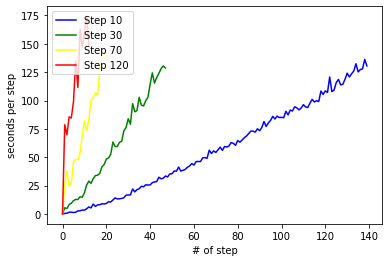

In [32]:
fig, ax = plt.subplots()
# ax.plot(range(len(step1)), ricalcola_lista(step1), label='Step 1', color='orange')
ax.plot(range(len(step10)), ricalcola_lista(step10), label='Step 10', color='blue')
ax.plot(range(len(step30)), ricalcola_lista(step30), label='Step 30', color='green')
ax.plot(range(len(step70)), ricalcola_lista(step70), label='Step 70', color='yellow')
ax.plot(range(len(step120)), ricalcola_lista(step120), label='Step 120', color='red')
ax.legend(loc='upper left')
plt.xlabel('# of step')
plt.ylabel('seconds per step')

Text(0, 0.5, 'Total seconds')

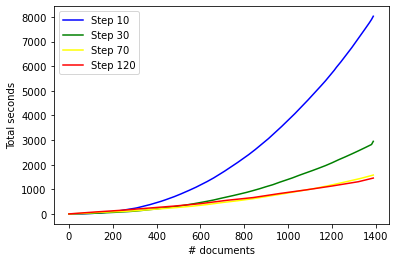

In [38]:
fig, ax = plt.subplots()
# ax.plot(list(range(1389)), step1, label='Step 1', color='orange')
ax.plot(list(range(0, 1388, 10)) + [1388], step10, label='Step 10', color='blue')
ax.plot(list(range(0, 1388, 30)) + [1388], step30, label='Step 30', color='green')
ax.plot(list(range(0, 1388, 70)) + [1388], step70, label='Step 70', color='yellow')
ax.plot(list(range(0, 1388, 120)) + [1388], step120, label='Step 120', color='red')
ax.legend(loc='upper left')
plt.xlabel('# documents')
plt.ylabel('Total seconds')

plot of scores in times

In [39]:
b3_120 ,ceaf_120 = get_scores("D:/Sgmon/Documents/Magistrale/TESI/Results_mixed/TimeEvolving/step_120/")
b3_70 ,ceaf_70 = get_scores("D:/Sgmon/Documents/Magistrale/TESI/Results_mixed/TimeEvolving/step_70/")
b3_30 ,ceaf_30 = get_scores("D:/Sgmon/Documents/Magistrale/TESI/Results_mixed/TimeEvolving/step_30/")
b3_10 ,ceaf_10 = get_scores("D:/Sgmon/Documents/Magistrale/TESI/Results_mixed/Best/")
b3_1 ,ceaf_1 = get_scores("D:/Sgmon/Documents/Magistrale/TESI/Results_mixed/TimeEvolving/step_1/")

Text(0, 0.5, '# documents')

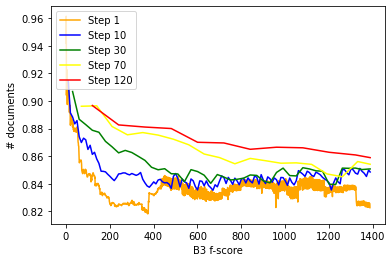

In [45]:
fig, ax = plt.subplots()
ax.plot(list(range(0, 1388)), b3_1, label='Step 1', color='orange')
ax.plot(list(range(11, 1388, 10)) + [1388], b3_10, label='Step 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], b3_30, label='Step 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], b3_70, label='Step 70', color='yellow')
ax.plot(list(range(121, 1388, 120)) + [1388], b3_120, label='Step 120', color='red')
ax.legend(loc='upper left')
plt.xlabel('B3 f-score')
plt.ylabel('# documents')

Text(0, 0.5, '# documents')

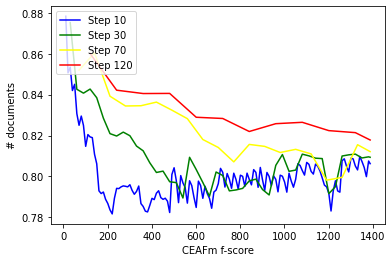

In [27]:
fig, ax = plt.subplots()
ax.plot(list(range(11, 1388, 10)) + [1388], ceaf_10, label='Step 10', color='blue')
ax.plot(list(range(31, 1388, 30)) + [1388], ceaf_30, label='Step 30', color='green')
ax.plot(list(range(71, 1388, 70)) + [1388], ceaf_70, label='Step 70', color='yellow')
ax.plot(list(range(121, 1388, 120)) + [1388], ceaf_120, label='Step 120', color='red')
ax.legend(loc='upper left')
plt.xlabel('CEAFm f-score')
plt.ylabel('# documents')